# Two Moons

The following example is a binary classification domain adaptation issue. The goal is to learn the classification task on the target data (black points) knowing only the labels on the source data (red and blue points).

In [1]:
!pip install adapt

In [2]:
import os

import adapt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, BatchNormalization
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.regularizers import l2

## Setup

In [3]:
def make_moons_da(n_samples=100, rotation=30, noise=0.05, random_state=0):
    Xs, ys = make_moons(n_samples=n_samples,
                        noise=noise,
                        random_state=random_state)
    Xs[:, 0] -= 0.5
    theta = np.radians(-rotation)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rot_matrix = np.array(
        ((cos_theta, -sin_theta),
         (sin_theta, cos_theta))
    )
    Xt = Xs.dot(rot_matrix)
    yt = ys
    return Xs, ys, Xt, yt

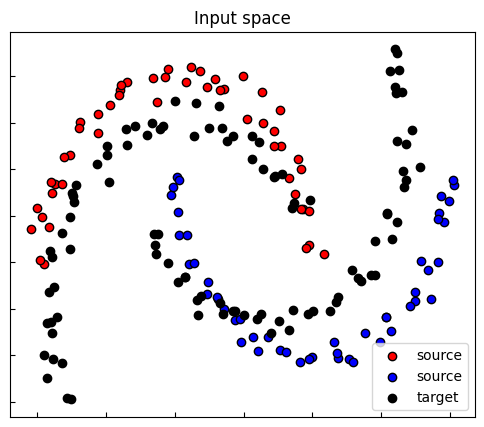

In [4]:
Xs, ys, Xt, yt = make_moons_da()

x_min, y_min = np.min([Xs.min(0), Xt.min(0)], 0)
x_max, y_max = np.max([Xs.max(0), Xt.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend(loc="lower right")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

## Network

In [5]:
def get_task():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

<a name="Source-Only"></a>
## Source Only

For source only, we use a DANN instance with lambda set to zero. Thus, the gradient of the discriminator is not back-propagated through the encoder.

In [6]:
from adapt.feature_based import DANN

In [7]:
src_only = DANN(task=get_task(), loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, lambda_=0., metrics=["acc"], gamma=10., random_state=0)

/usr/local/lib/python3.12/dist-packages/adapt/feature_based/_dann.py:115: UserWarning: the `gamma` argument has been removed from DANN. If you want to use the lambda update process, please use the `UpdateLambda` callback from adapt.utils
  warnings.warn("the `gamma` argument has been removed from DANN."


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dann', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


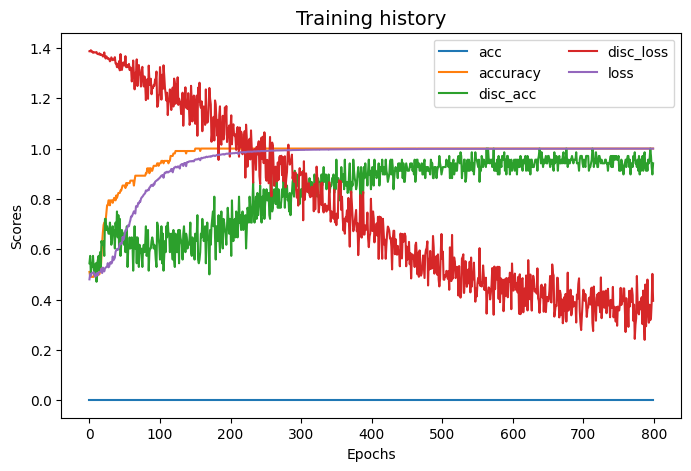

In [8]:
src_only.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(src_only.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [10]:
yt_pred = src_only.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = src_only.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((src_only.transform(Xs),
                        src_only.transform(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


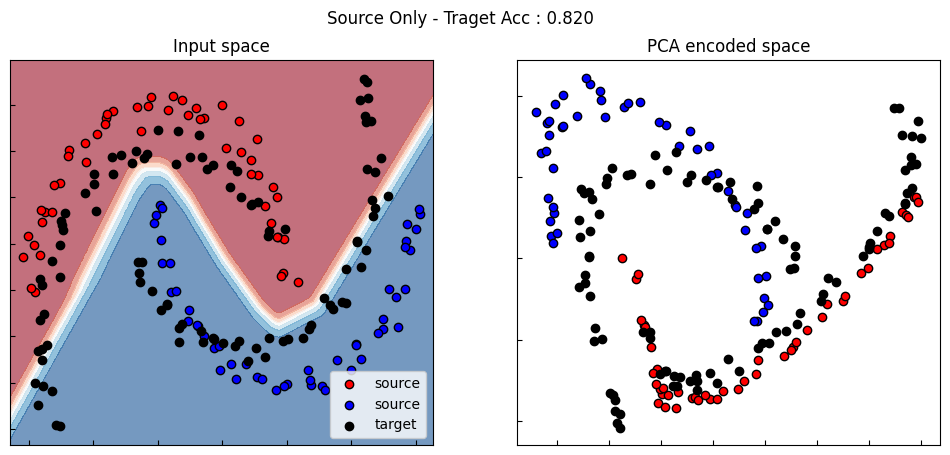

In [11]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()

<a name="DANN"></a>
## [DANN](https://adapt-python.github.io/adapt/generated/adapt.feature_based.DANN.html)

In [12]:
dann = DANN(task=get_task(), loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, lambda_=1., metrics=["acc"], random_state=0)

/usr/local/lib/python3.12/dist-packages/adapt/feature_based/_dann.py:115: UserWarning: the `gamma` argument has been removed from DANN. If you want to use the lambda update process, please use the `UpdateLambda` callback from adapt.utils
  warnings.warn("the `gamma` argument has been removed from DANN."


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dann_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


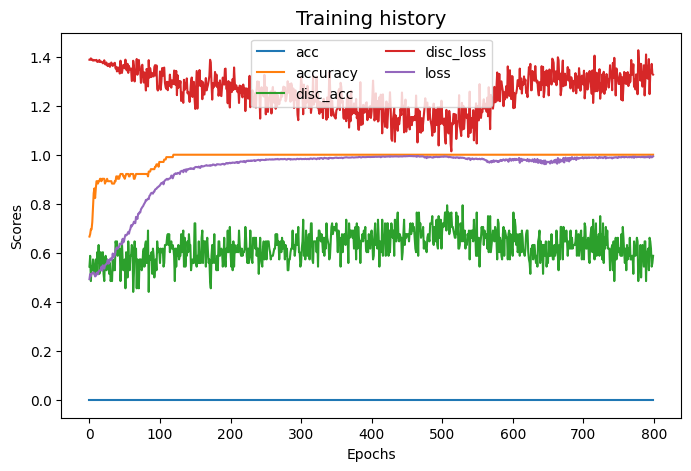

In [13]:
dann.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [14]:
yt_pred = dann.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = dann.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((dann.encoder_.predict(Xs),
                        dann.encoder_.predict(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


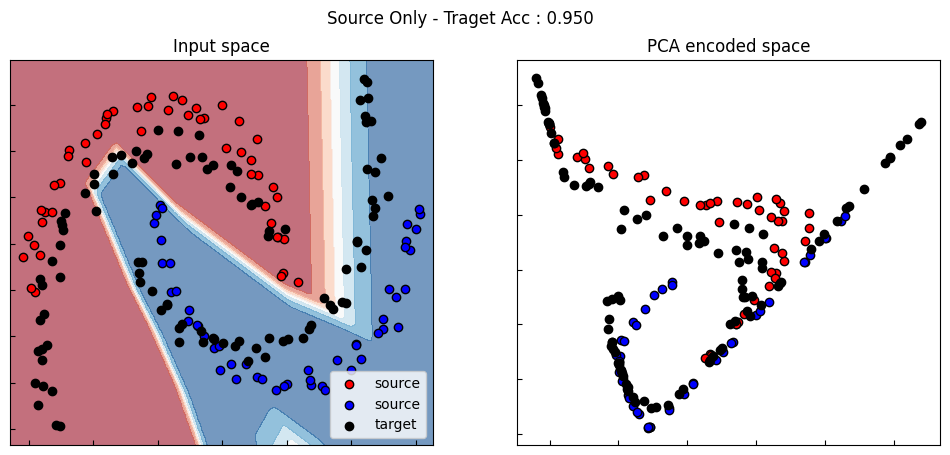

In [15]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()

<a name="ADDA"></a>
## [ADDA](https://adapt-python.github.io/adapt/generated/adapt.feature_based.ADDA.html)

In [17]:
from adapt.feature_based import ADDA

In [18]:
adda = ADDA(task=get_task(),
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'adda', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


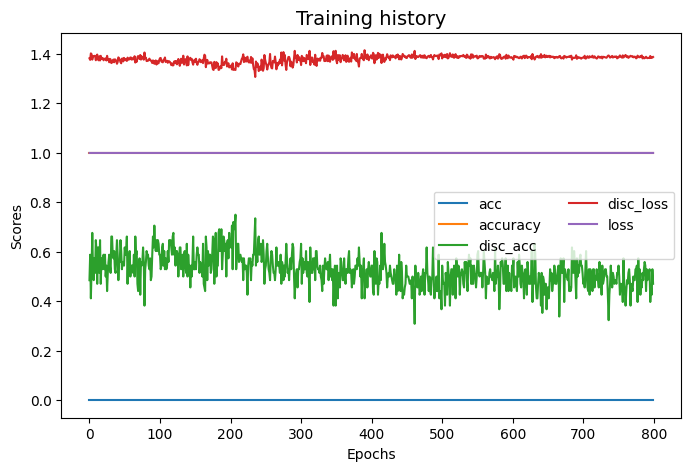

In [19]:
adda.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(adda.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [24]:
yt_pred = adda.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = adda.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((adda.transform(Xs, domain="src"),
                        adda.transform(Xt, domain="tgt")))
X_pca = PCA(2).fit_transform(X_pca)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


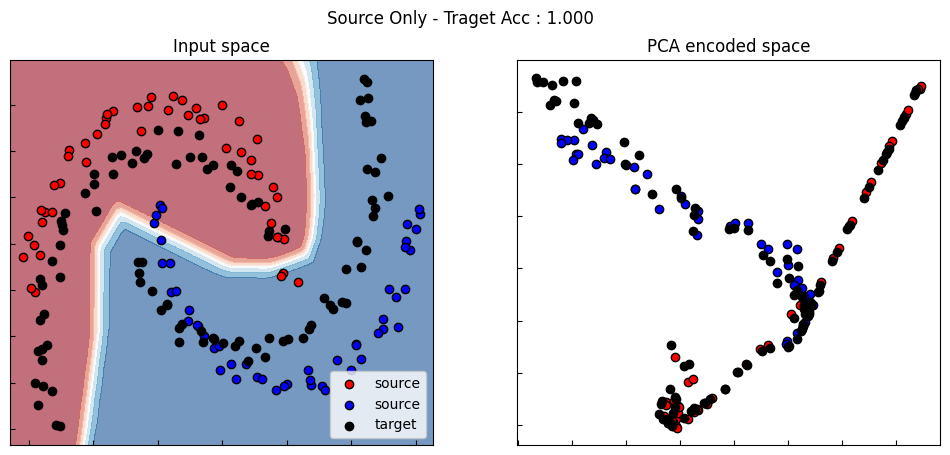

In [25]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()

<a name="DeepCORAL"></a>
## [DeepCORAL](https://adapt-python.github.io/adapt/generated/adapt.feature_based.DeepCORAL.html)

In [27]:
from adapt.feature_based import DeepCORAL

In [28]:
dcoral = DeepCORAL(encoder=src_only.encoder_,
                   task=src_only.task_, lambda_=1000.,
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, metrics=["acc"], random_state=0)

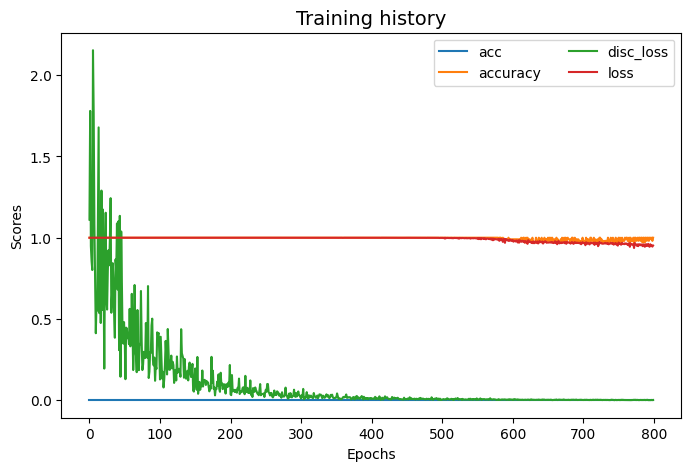

In [29]:
dcoral.fit(Xs, ys, Xt, yt, epochs=800, batch_size=34, verbose=0);
pd.DataFrame(dcoral.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [32]:
yt_pred = dcoral.predict(Xt)
acc = accuracy_score(yt, yt_pred>0.5)

yp_grid = dcoral.predict(X_grid).reshape(100, 100)

X_pca = np.concatenate((dcoral.transform(Xs),
                        dcoral.transform(Xt)))
X_pca = PCA(2).fit_transform(X_pca)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


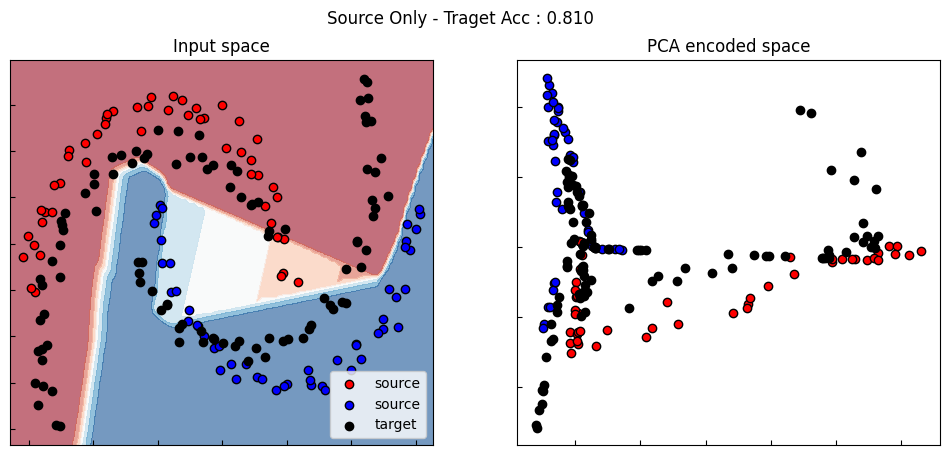

In [33]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_title("PCA encoded space")
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            label="source", edgecolors='k', c="red")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            label="source", edgecolors='k', c="blue")
ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
            label="target", edgecolors='k', c="black")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')
fig.suptitle("Source Only - Traget Acc : %.3f"%acc)
plt.show()

## Observe Dynamic

In [55]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

class StoreResultsCallback(tf.keras.callbacks.Callback):
    def __init__(self, Xs, Xt, yt, X_grid, K=5):
        super().__init__()
        self.Xs = tf.identity(Xs)
        self.Xt = tf.identity(Xt)
        self.yt = yt
        self.X_grid = tf.identity(X_grid)
        self.K = K

        # Storage lists
        self.target_preds = []
        self.target_acc = []
        self.grid_preds = []
        self.X_pca_list = []

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.K == 0:
            # Predict target
            yt_pred = self.model(self.Xt).numpy()
            acc = accuracy_score(self.yt, (yt_pred > 0.5).astype(int))

            # Predict grid
            yp_grid = self.model(self.X_grid).numpy().reshape(100, 100)

            # Get encoded features and PCA
            X_encoded = np.concatenate(
                [self.model.encoder_(self.Xs).numpy(),
                 self.model.encoder_(self.Xt).numpy()],
                axis=0
            )
            X_pca = X_encoded.copy()

            # Store
            self.target_preds.append(yt_pred)
            self.target_acc.append(acc)
            self.grid_preds.append(yp_grid)
            self.X_pca_list.append(X_pca)

            print(f"\n[Callback] Epoch {epoch+1}: target acc = {acc:.4f}")

In [56]:
def get_task():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

def get_encoder():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(2, activation=None))
    return model

In [57]:
callbacks = StoreResultsCallback(Xs, Xt, yt, X_grid)

dann = DANN(task=get_task(), encoder=get_encoder(),
            loss="bce", optimizer=Adam(0.001, beta_1=0.5),
            copy=True, lambda_=1., metrics=["acc"], random_state=0)

In [62]:
dann.fit(Xs, ys, Xt, yt, epochs=300, batch_size=34, verbose=1, callbacks=callbacks);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

callback = callbacks

cm = plt.cm.RdBu
num_frames = len(callback.grid_preds)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Initial plots
im1 = ax1.contourf(x_grid, y_grid, callback.grid_preds[0], cmap=cm, alpha=0.6)
sc1_s0 = ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
sc1_s1 = ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
sc1_t = ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
ax1.legend()
ax1.set_title("Input space")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='in')

sc2_s0 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==0],
                     callback.X_pca_list[0][:len(Xs), 1][ys==0],
                     c="red", edgecolors="k", label="source")
sc2_s1 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==1],
                     callback.X_pca_list[0][:len(Xs), 1][ys==1],
                     c="blue", edgecolors="k", label="source")
sc2_t = ax2.scatter(callback.X_pca_list[0][len(Xs):, 0],
                     callback.X_pca_list[0][len(Xs):, 1],
                     c="black", edgecolors="k", label="target")
ax2.set_title("Encoded space")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction='in')

# Animation function
def animate(i):
    ax1.clear()
    ax2.clear()

    # Input space contour
    ax1.contourf(x_grid, y_grid, callback.grid_preds[i], cmap=cm, alpha=0.6)
    ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
    ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
    ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
    ax1.set_title("Input space")
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in')

    # PCA encoded space
    X_pca = callback.X_pca_list[i]
    ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
                c="red", edgecolors="k", label="source")
    ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
                c="blue", edgecolors="k", label="source")
    ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
                c="black", edgecolors="k", label="target")
    ax2.set_title("Encoded space")
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(direction='in')

    # Overall title with current accuracy
    fig.suptitle(f"Epoch snapshot {i+1} - Target Acc: {callback.target_acc[i]:.3f}")

    return [ax1, ax2]

# Create the animation
anim = FuncAnimation(fig, animate, frames=num_frames, interval=500, blit=False, repeat=True)
anim

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from matplotlib import cm

callback = callbacks

num_frames = len(callback.grid_preds)
cm_target = cm.viridis  # Colormap for target points
classes_target = np.unique(yt)  # target labels

# Map each class to a color in the colormap
colors_target = ["cool", "spring"]

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Initial plots
im1 = ax1.contourf(x_grid, y_grid, callback.grid_preds[0], cmap=cm.RdBu, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
# Target points with class colors
sc1_targets = []
for c in classes_target:
    sc = ax1.scatter(Xt[yt==c, 0], Xt[yt==c, 1],
                     cmap=colors_target[c], c=Xt[yt==c, 0],
                     edgecolors="k", label=f"target class {c}")
    sc1_targets.append(sc)
ax1.set_title("Input space")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='in')

# PCA encoded space
X_pca = callback.X_pca_list[0]
ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
            c="red", edgecolors="k")
ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
            c="blue", edgecolors="k")
sc2_targets = []
for c in classes_target:
    sc = ax2.scatter(X_pca[len(Xs):, 0][yt==c], X_pca[len(Xs):, 1][yt==c],
                     cmap=colors_target[c], c=Xt[yt==c, 0], edgecolors="k")
    sc2_targets.append(sc)
ax2.set_title("Encoded space")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction='in')

def animate(i):
    ax1.clear()
    ax2.clear()

    # Input space contour
    ax1.contourf(x_grid, y_grid, callback.grid_preds[i], cmap=cm.RdBu, alpha=0.6)
    ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
    ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
    for c in classes_target:
        ax1.scatter(Xt[yt==c, 0], Xt[yt==c, 1],
                     cmap=colors_target[c], c=Xt[yt==c, 0],
                     edgecolors="k", label=f"target class {c}")
    ax1.set_title("Input space")
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in')

    # PCA encoded space
    X_pca = callback.X_pca_list[i]
    ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
                c="red", edgecolors="k")
    ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
                c="blue", edgecolors="k")
    for c in classes_target:
        ax2.scatter(X_pca[len(Xs):, 0][yt==c], X_pca[len(Xs):, 1][yt==c],
                     cmap=colors_target[c], c=Xt[yt==c, 0], edgecolors="k")
    ax2.set_title("Encoded space")
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(direction='in')

    fig.suptitle(f"Epoch snapshot {i+1} - Target Acc: {callback.target_acc[i]:.3f}")

    return []

anim = FuncAnimation(fig, animate, frames=num_frames, interval=500, blit=False, repeat=True)
anim

### Try Larger Networks

In [76]:
def get_task():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

def get_encoder():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(2, activation=None))
    return model

In [77]:
callbacks = StoreResultsCallback(Xs, Xt, yt, X_grid)

dann = DANN(task=get_task(), encoder=get_encoder(),
            loss="bce", optimizer=tf.keras.optimizers.Adam(0.01),
            copy=True, lambda_=1., metrics=["acc"], random_state=0)

In [78]:
callbacks = StoreResultsCallback(Xs, Xt, yt, X_grid)

In [92]:
dann.fit(Xs, ys, Xt, yt, epochs=300, batch_size=34, verbose=1, callbacks=callbacks);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [3]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

callback = callbacks

cm = plt.cm.RdBu
num_frames = len(callback.grid_preds)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Initial plots
im1 = ax1.contourf(x_grid, y_grid, callback.grid_preds[0], cmap=cm, alpha=0.6)
sc1_s0 = ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
sc1_s1 = ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
sc1_t = ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
ax1.legend()
ax1.set_title("Input space")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='in')

sc2_s0 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==0],
                     callback.X_pca_list[0][:len(Xs), 1][ys==0],
                     c="red", edgecolors="k", label="source")
sc2_s1 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==1],
                     callback.X_pca_list[0][:len(Xs), 1][ys==1],
                     c="blue", edgecolors="k", label="source")
sc2_t = ax2.scatter(callback.X_pca_list[0][len(Xs):, 0],
                     callback.X_pca_list[0][len(Xs):, 1],
                     c="black", edgecolors="k", label="target")
ax2.set_title("Encoded space")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction='in')

# Animation function
def animate(i):
    ax1.clear()
    ax2.clear()

    # Input space contour
    ax1.contourf(x_grid, y_grid, callback.grid_preds[i], cmap=cm, alpha=0.6)
    ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
    ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
    ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
    ax1.set_title("Input space")
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in')

    # PCA encoded space
    X_pca = callback.X_pca_list[i]
    ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
                c="red", edgecolors="k", label="source")
    ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
                c="blue", edgecolors="k", label="source")
    ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
                c="black", edgecolors="k", label="target")
    ax2.set_title("Encoded space")
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(direction='in')

    # Overall title with current accuracy
    fig.suptitle(f"Epoch snapshot {i+1} - Target Acc: {callback.target_acc[i]:.3f}")

    return [ax1, ax2]

# Create the animation
anim = FuncAnimation(fig, animate, frames=num_frames, interval=500, blit=False, repeat=True)
anim

### Try SGD

In [85]:
callbacks = StoreResultsCallback(Xs, Xt, yt, X_grid)

dann = DANN(task=get_task(), encoder=get_encoder(),
            loss="bce", optimizer=tf.keras.optimizers.SGD(0.1),
            copy=True, lambda_=1., metrics=["acc"], random_state=0)

In [86]:
callbacks = StoreResultsCallback(Xs, Xt, yt, X_grid)

In [93]:
dann.fit(Xs, ys, Xt, yt, epochs=300, batch_size=34, verbose=1, callbacks=callbacks);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [4]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

callback = callbacks

cm = plt.cm.RdBu
num_frames = len(callback.grid_preds)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Initial plots
im1 = ax1.contourf(x_grid, y_grid, callback.grid_preds[0], cmap=cm, alpha=0.6)
sc1_s0 = ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
sc1_s1 = ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
sc1_t = ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
ax1.legend()
ax1.set_title("Input space")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='in')

sc2_s0 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==0],
                     callback.X_pca_list[0][:len(Xs), 1][ys==0],
                     c="red", edgecolors="k", label="source")
sc2_s1 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==1],
                     callback.X_pca_list[0][:len(Xs), 1][ys==1],
                     c="blue", edgecolors="k", label="source")
sc2_t = ax2.scatter(callback.X_pca_list[0][len(Xs):, 0],
                     callback.X_pca_list[0][len(Xs):, 1],
                     c="black", edgecolors="k", label="target")
ax2.set_title("Encoded space")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction='in')

# Animation function
def animate(i):
    ax1.clear()
    ax2.clear()

    # Input space contour
    ax1.contourf(x_grid, y_grid, callback.grid_preds[i], cmap=cm, alpha=0.6)
    ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
    ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
    ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
    ax1.set_title("Input space")
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in')

    # PCA encoded space
    X_pca = callback.X_pca_list[i]
    ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
                c="red", edgecolors="k", label="source")
    ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
                c="blue", edgecolors="k", label="source")
    ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
                c="black", edgecolors="k", label="target")
    ax2.set_title("Encoded space")
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(direction='in')

    # Overall title with current accuracy
    fig.suptitle(f"Epoch snapshot {i+1} - Target Acc: {callback.target_acc[i]:.3f}")

    return [ax1, ax2]

# Create the animation
anim = FuncAnimation(fig, animate, frames=num_frames, interval=500, blit=False, repeat=True)
anim

## [MDD](https://adapt-python.github.io/adapt/generated/adapt.feature_based.MDD.html)

In [89]:
from adapt.feature_based import MDD

In [94]:
callbacks = StoreResultsCallback(Xs, Xt, yt, X_grid)

mdd = MDD(task=get_task(), encoder=get_encoder(),
            loss="bce", optimizer=tf.keras.optimizers.SGD(0.05),
            copy=True, lambda_=.1, metrics=["acc"], random_state=0)

In [94]:
mdd.fit(Xs, ys, Xt, yt, epochs=300, batch_size=34, verbose=1, callbacks=callbacks);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

callback = callbacks

cm = plt.cm.RdBu
num_frames = len(callback.grid_preds)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Initial plots
im1 = ax1.contourf(x_grid, y_grid, callback.grid_preds[0], cmap=cm, alpha=0.6)
sc1_s0 = ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
sc1_s1 = ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
sc1_t = ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
ax1.legend()
ax1.set_title("Input space")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='in')

sc2_s0 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==0],
                     callback.X_pca_list[0][:len(Xs), 1][ys==0],
                     c="red", edgecolors="k", label="source")
sc2_s1 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==1],
                     callback.X_pca_list[0][:len(Xs), 1][ys==1],
                     c="blue", edgecolors="k", label="source")
sc2_t = ax2.scatter(callback.X_pca_list[0][len(Xs):, 0],
                     callback.X_pca_list[0][len(Xs):, 1],
                     c="black", edgecolors="k", label="target")
ax2.set_title("Encoded space")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction='in')

# Animation function
def animate(i):
    ax1.clear()
    ax2.clear()

    # Input space contour
    ax1.contourf(x_grid, y_grid, callback.grid_preds[i], cmap=cm, alpha=0.6)
    ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
    ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
    ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
    ax1.set_title("Input space")
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in')

    # PCA encoded space
    X_pca = callback.X_pca_list[i]
    ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
                c="red", edgecolors="k", label="source")
    ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
                c="blue", edgecolors="k", label="source")
    ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
                c="black", edgecolors="k", label="target")
    ax2.set_title("Encoded space")
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(direction='in')

    # Overall title with current accuracy
    fig.suptitle(f"Epoch snapshot {i+1} - Target Acc: {callback.target_acc[i]:.3f}")

    return [ax1, ax2]

# Create the animation
anim = FuncAnimation(fig, animate, frames=num_frames, interval=500, blit=False, repeat=True)
anim

## Class Imbalance (Label Shift)

In [89]:
def make_moons_da_imbalance(n_samples=100, rotation=30, noise=0.05, random_state=0):
    Xs, ys = make_moons(n_samples=n_samples,
                        noise=noise,
                        random_state=random_state)
    Xs[:, 0] -= 0.5
    theta = np.radians(-rotation)
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    rot_matrix = np.array(
        ((cos_theta, -sin_theta),
         (sin_theta, cos_theta))
    )

    Xt, yt = make_moons(n_samples=10*n_samples,
                        noise=noise,
                        random_state=random_state)
    Xt[:, 0] -= 0.5
    Xt = Xt.dot(rot_matrix)

    index0 = np.random.choice(np.argwhere((yt == 0)).ravel(), size=int(0.8*n_samples))
    index1 = np.random.choice(np.argwhere((yt == 1)).ravel(), size=int(0.2*n_samples))

    yt = np.concatenate((yt[index0], yt[index1]))
    Xt = np.concatenate((Xt[index0], Xt[index1]))
    return Xs, ys, Xt, yt

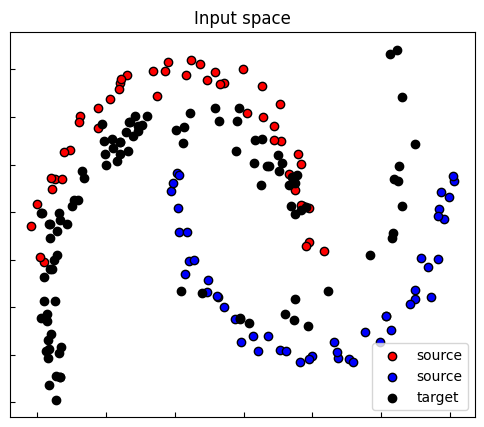

In [90]:
Xs, ys, Xt, yt = make_moons_da_imbalance()

x_min, y_min = np.min([Xs.min(0), Xt.min(0)], 0)
x_max, y_max = np.max([Xs.max(0), Xt.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend(loc="lower right")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

In [95]:
callbacks = StoreResultsCallback(Xs, Xt, yt, X_grid)

mdd = MDD(task=get_task(), encoder=get_encoder(),
            loss="bce", optimizer=tf.keras.optimizers.SGD(0.05),
            copy=True, lambda_=.1, metrics=["acc"], random_state=0)

In [96]:
mdd.fit(Xs, ys, Xt, yt, epochs=300, batch_size=34, verbose=1, callbacks=callbacks);
pd.DataFrame(dann.history_).plot(figsize=(8, 5))
plt.title("Training history", fontsize=14); plt.xlabel("Epochs"); plt.ylabel("Scores")
plt.legend(ncol=2)
plt.show()

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

callback = callbacks

cm = plt.cm.RdBu
num_frames = len(callback.grid_preds)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Initial plots
im1 = ax1.contourf(x_grid, y_grid, callback.grid_preds[0], cmap=cm, alpha=0.6)
sc1_s0 = ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
sc1_s1 = ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
sc1_t = ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
ax1.legend()
ax1.set_title("Input space")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction='in')

sc2_s0 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==0],
                     callback.X_pca_list[0][:len(Xs), 1][ys==0],
                     c="red", edgecolors="k", label="source")
sc2_s1 = ax2.scatter(callback.X_pca_list[0][:len(Xs), 0][ys==1],
                     callback.X_pca_list[0][:len(Xs), 1][ys==1],
                     c="blue", edgecolors="k", label="source")
sc2_t = ax2.scatter(callback.X_pca_list[0][len(Xs):, 0],
                     callback.X_pca_list[0][len(Xs):, 1],
                     c="black", edgecolors="k", label="target")
ax2.set_title("Encoded space")
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction='in')

# Animation function
def animate(i):
    ax1.clear()
    ax2.clear()

    # Input space contour
    ax1.contourf(x_grid, y_grid, callback.grid_preds[i], cmap=cm, alpha=0.6)
    ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], c="red", edgecolors="k", label="source")
    ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], c="blue", edgecolors="k", label="source")
    ax1.scatter(Xt[:, 0], Xt[:, 1], c="black", edgecolors="k", label="target")
    ax1.set_title("Input space")
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in')

    # PCA encoded space
    X_pca = callback.X_pca_list[i]
    ax2.scatter(X_pca[:len(Xs), 0][ys==0], X_pca[:len(Xs), 1][ys==0],
                c="red", edgecolors="k", label="source")
    ax2.scatter(X_pca[:len(Xs), 0][ys==1], X_pca[:len(Xs), 1][ys==1],
                c="blue", edgecolors="k", label="source")
    ax2.scatter(X_pca[len(Xs):, 0], X_pca[len(Xs):, 1],
                c="black", edgecolors="k", label="target")
    ax2.set_title("Encoded space")
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(direction='in')

    # Overall title with current accuracy
    fig.suptitle(f"Epoch snapshot {i+1} - Target Acc: {callback.target_acc[i]:.3f}")

    return [ax1, ax2]

# Create the animation
anim = FuncAnimation(fig, animate, frames=num_frames, interval=500, blit=False, repeat=True)
anim

## Optimal Transport

In [11]:
!pip install skada

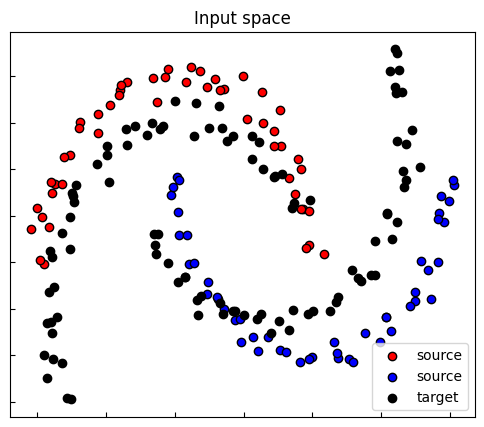

In [68]:
Xs, ys, Xt, yt = make_moons_da()

x_min, y_min = np.min([Xs.min(0), Xt.min(0)], 0)
x_max, y_max = np.max([Xs.max(0), Xt.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend(loc="lower right")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

In [69]:
from skada import OTMapping

In [73]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", random_state=0, C=10., gamma=1.)
model.fit(Xs, ys)

yp_grid = model.predict(X_grid)
yp_grid = yp_grid.reshape(x_grid.shape)

target_acc = model.score(Xt, yt)

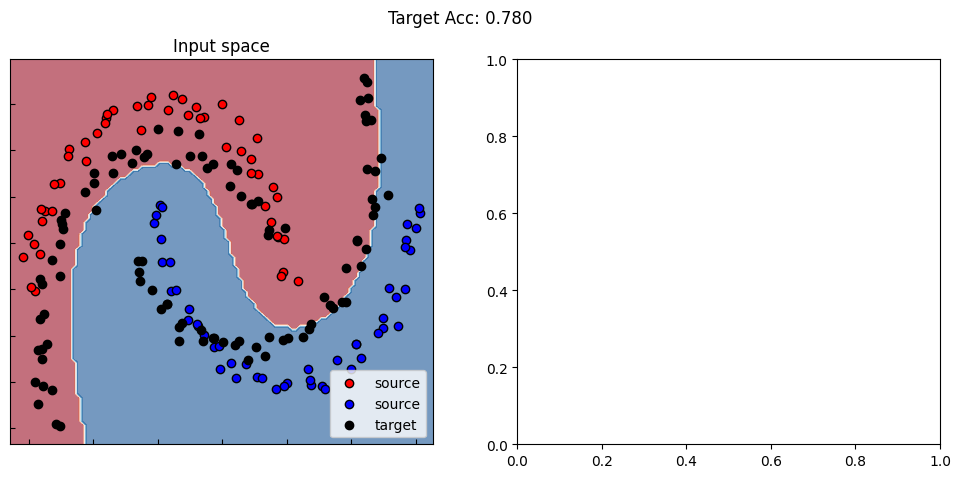

In [74]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

fig.suptitle(f"Target Acc: {target_acc:.3f}")

plt.show()

In [76]:
model = OTMapping(base_estimator=SVC(kernel="rbf", random_state=0, C=10., gamma=1.))

X = np.concatenate((Xs, Xt))
y = np.concatenate((ys, np.full(yt.shape[0], np.nan)))
sample_domain = np.concatenate((np.ones(Xs.shape[0]), -2 * np.ones(Xt.shape[0])))

model.fit(X, y, sample_domain=sample_domain)

yp_grid = model.predict(X_grid)
yp_grid = yp_grid.reshape(x_grid.shape)

target_acc = model.score(Xt, yt)

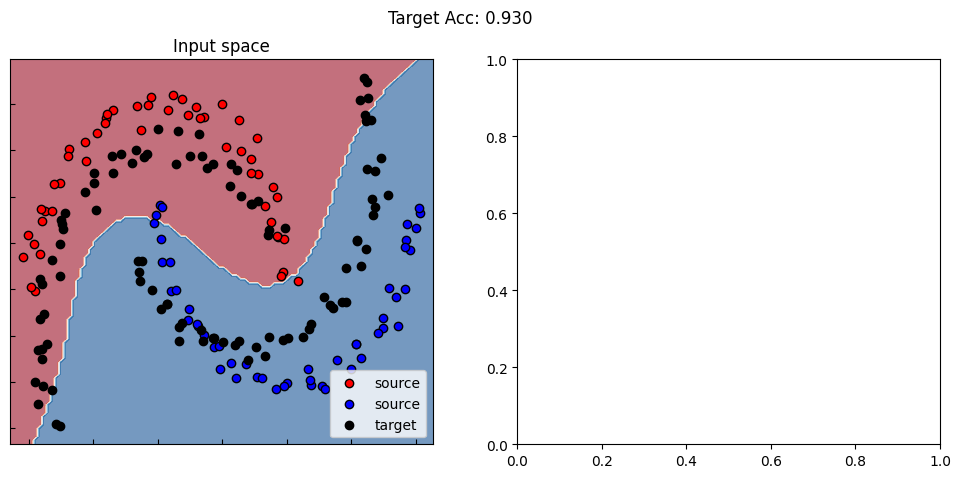

In [77]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

fig.suptitle(f"Target Acc: {target_acc:.3f}")

plt.show()

In [78]:
index_tgt = np.argmax(model.steps[0][1].base_estimator_.ot_transport_.coupling_, axis=1)

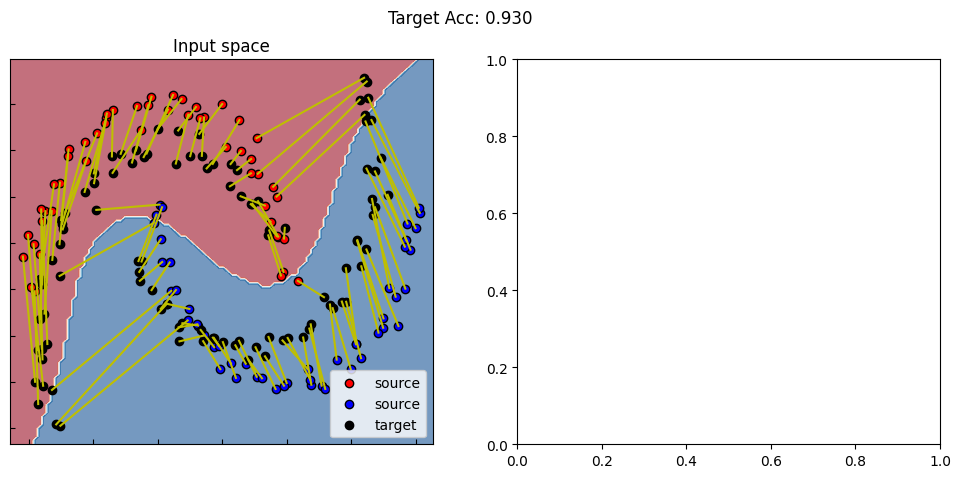

In [80]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")

for i in range(Xs.shape[0]):
  ax1.plot([Xs[i, 0], Xt[index_tgt[i], 0]],
           [Xs[i, 1], Xt[index_tgt[i], 1]], c="y")

ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

fig.suptitle(f"Target Acc: {target_acc:.3f}")

plt.show()

## OT Class Imbalance

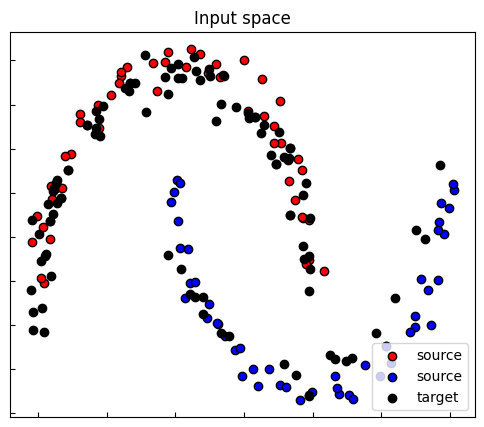

In [98]:
Xs, ys, Xt, yt = make_moons_da_imbalance(rotation=10, )

x_min, y_min = np.min([Xs.min(0), Xt.min(0)], 0)
x_max, y_max = np.max([Xs.max(0), Xt.max(0)], 0)
x_grid, y_grid = np.meshgrid(np.linspace(x_min-0.1, x_max+0.1, 100),
                             np.linspace(y_min-0.1, y_max+0.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title("Input space")
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend(loc="lower right")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')
plt.show()

In [99]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", random_state=0, C=10., gamma=1.)
model.fit(Xs, ys)

yp_grid = model.predict(X_grid)
yp_grid = yp_grid.reshape(x_grid.shape)

target_acc = model.score(Xt, yt)

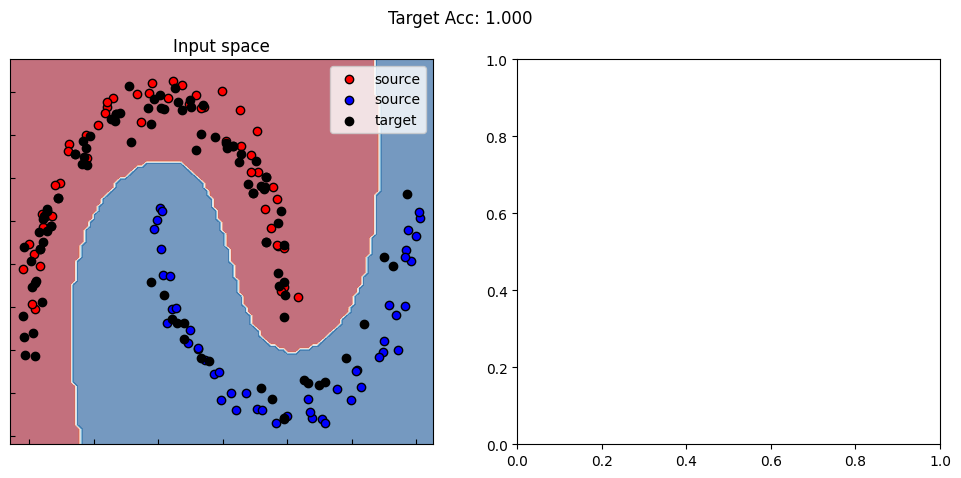

In [100]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

fig.suptitle(f"Target Acc: {target_acc:.3f}")

plt.show()

In [101]:
model = OTMapping(base_estimator=SVC(kernel="rbf", random_state=0, C=10., gamma=1.))

X = np.concatenate((Xs, Xt))
y = np.concatenate((ys, np.full(yt.shape[0], np.nan)))
sample_domain = np.concatenate((np.ones(Xs.shape[0]), -2 * np.ones(Xt.shape[0])))

model.fit(X, y, sample_domain=sample_domain)

yp_grid = model.predict(X_grid)
yp_grid = yp_grid.reshape(x_grid.shape)

target_acc = model.score(Xt, yt)

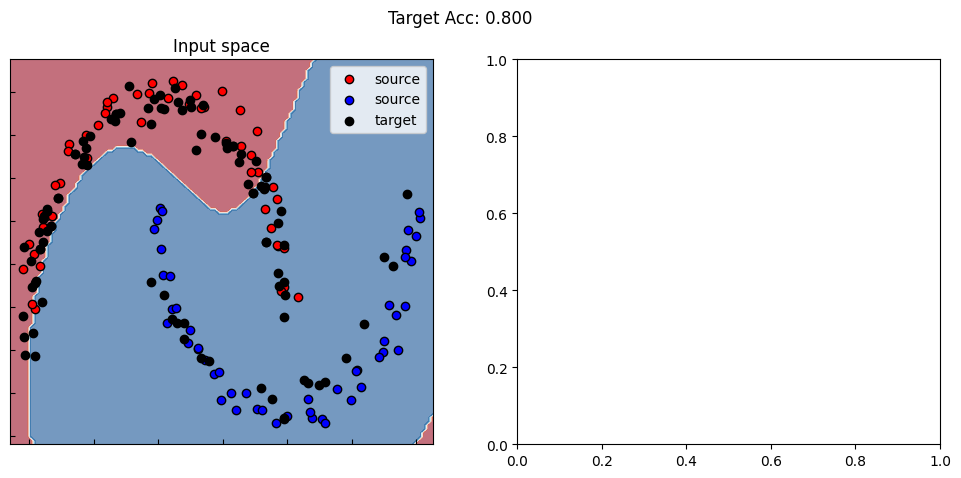

In [102]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")
ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

fig.suptitle(f"Target Acc: {target_acc:.3f}")

plt.show()

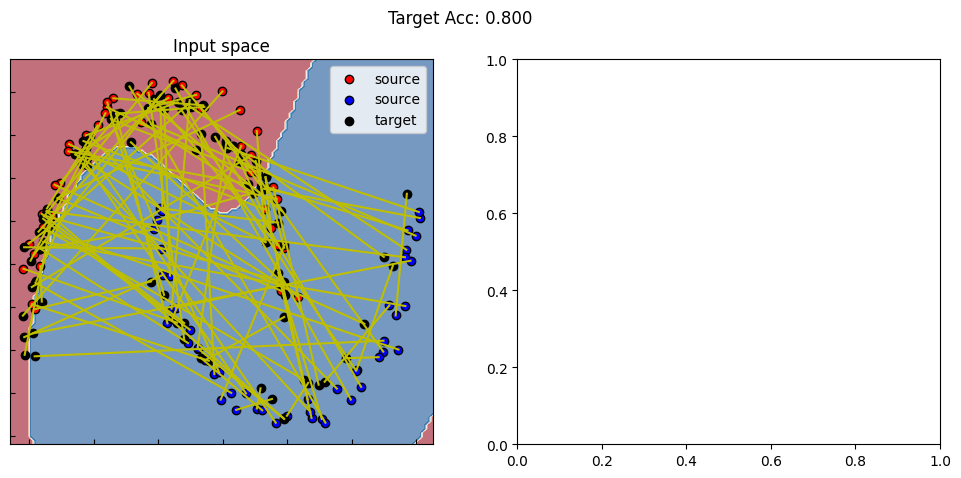

In [103]:
cm = plt.cm.RdBu
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title("Input space")
ax1.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=0.6)
ax1.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k', c="red")
ax1.scatter(Xs[ys==1, 0], Xs[ys==1, 1], label="source", edgecolors='k', c="blue")
ax1.scatter(Xt[:, 0], Xt[:, 1], label="target", edgecolors='k', c="black")

for i in range(Xs.shape[0]):
  ax1.plot([Xs[i, 0], Xt[index_tgt[i], 0]],
           [Xs[i, 1], Xt[index_tgt[i], 1]], c="y")

ax1.legend()
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

fig.suptitle(f"Target Acc: {target_acc:.3f}")

plt.show()